# Time Series Forecasting with XGBoost

In [1]:
from random import gauss
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
sys.path.insert(2,'..')
import functions
import xgboost as xgb
from sklearn import preprocessing
import annualized_rv as arv
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# reads in the historic implied vol data calculated in the dailyaverageIV notebook

aaplHistIV = pd.read_pickle('historicImpliedVolData/aapl_mean_iv_2017_2022.pkl')
googHistIV = pd.read_pickle('historicImpliedVolData/goog_mean_iv_2017_2022.pkl')
msftHistIV = pd.read_pickle('historicImpliedVolData/msft_mean_iv_2017_2022.pkl')
ndxHistIV = pd.read_pickle('historicImpliedVolData/ndx_mean_iv_2017_2022.pkl')
spyHistIV = pd.read_pickle('historicImpliedVolData/spc_mean_iv_2017_2022.pkl')


In [3]:
spyHistIV = spyHistIV.rename(columns = {'date':'Date'}) #renaming date column to Date for consistency
spyHistIV = spyHistIV.set_index('Date',drop = True) #setting index to date

In [4]:
#grab spy  from yfinance

spyHistory = yf.download('^GSPC', start='2016-01-01', end='2023-12-31',progress=False)
#calculate realised vol
window =21 #realisedVol window size
spyHistory['Daily Return'] = spyHistory['Adj Close'].pct_change()
spyHistory['21dRealisedVol'] = spyHistory['Daily Return'].rolling(window=window).std() * np.sqrt(252)


[*********************100%%**********************]  1 of 1 completed


In [5]:
historicIVSeries = spyHistIV['average_iv']
historicVolumeSeries = spyHistory['Volume'].rolling(21).mean()['2017':'2021']
dailyReturnSeries= spyHistory['Daily Return']['2017':'2021']
dailyRealisedVolSeries = spyHistory['21dRealisedVol']['2017':'2021']
df_combined = pd.concat([historicIVSeries,dailyReturnSeries,dailyRealisedVolSeries,historicVolumeSeries], axis=1)

# Scale the data
scaler = preprocessing.StandardScaler().fit(df_combined)
scaled_data = scaler.transform(df_combined)

In [6]:
data = scaled_data
seq_length = 60
n_features = data.shape[1]


In [7]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length - 3):
        x = data[i:(i + seq_length)]
        y = data[(i + seq_length), 0]  # Next 3-day IV
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [8]:
X, y = create_sequences(data, seq_length)

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]



In [9]:
#reshape data for xgboost
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])

In [10]:
model = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Evaluation

In [11]:


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred = model.predict(X_test)
y_test = np.array(y_test)  # Ensure y_test is a numpy array for consistency

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate R^2
r2 = r2_score(y_test, y_pred)
print("R squared:", r2)


Mean Squared Error: 0.04777484432117391
Root Mean Squared Error: 0.21857457382132514
Mean Absolute Error: 0.16837472095515635
R squared: 0.48583615788768797


# Using other data

In [1]:
def preprocess_data(data,history_name, seq_length):
    data= data.rename(columns = {'date':'Date'}) #renaming date column to Date for consistency
    data = data.set_index('Date') #setting index to date

    #grab historical data from yfinance
    History = yf.download(history_name, start='2016-01-01', end='2023-12-31', progress = False);
    History['dailyReturn'] = np.log(History['Adj Close']/History['Adj Close'].shift(1))
    History['21dRealisedVol'] = History['dailyReturn'].rolling(window=window).std() * np.sqrt(252)

    historicIVSeries = data['average_iv']
    historicVolumeSeries = History['Volume'].rolling(21).mean()['2017':'2021']
    dailyReturnSeries= History['dailyReturn']['2017':'2021']
    dailyRealisedVolSeries = History['21dRealisedVol']['2017':'2021']
    df_combined = pd.concat([historicIVSeries,dailyReturnSeries,dailyRealisedVolSeries,historicVolumeSeries], axis=1)

    
    # Scale the data
    scaler = preprocessing.StandardScaler().fit(df_combined)
    scaled_data = scaler.transform(df_combined)

    X, y = create_sequences(scaled_data, seq_length)
    tscv = TimeSeriesSplit(n_splits=5)

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

    #reshape data for xgboost
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])

    return X_train, X_test, y_train, y_test

def evaluate_model(X_train, X_test, y_train, y_test):
    model = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_test = np.array(y_test)  # Ensure y_test is a numpy array for consistency

    # Calculate MSE
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)

    # Calculate RMSE
    rmse = np.sqrt(mse)
    print("Root Mean Squared Error:", rmse)

    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)
    print("Mean Absolute Error:", mae)

    # Calculate R^2
    r2 = r2_score(y_test, y_pred)
    print("R squared:", r2)

    plt.plot(y_test)
    plt.plot(y_pred)
    plt.show()
    return model

Mean Squared Error: 0.08839382423668245
Root Mean Squared Error: 0.29731098909505926
Mean Absolute Error: 0.23453006822948014
R squared: 0.6970585433516374


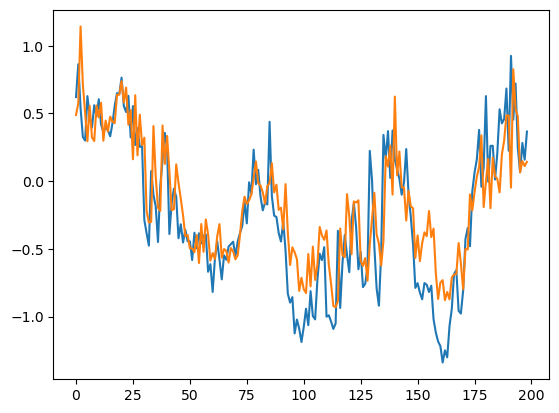

In [23]:
evaluate_model(*preprocess_data(aaplHistIV,'AAPL',60));

Mean Squared Error: 0.04963984066484903
Root Mean Squared Error: 0.22280000149203102
Mean Absolute Error: 0.17689715952233054
R squared: 0.46576463909543475


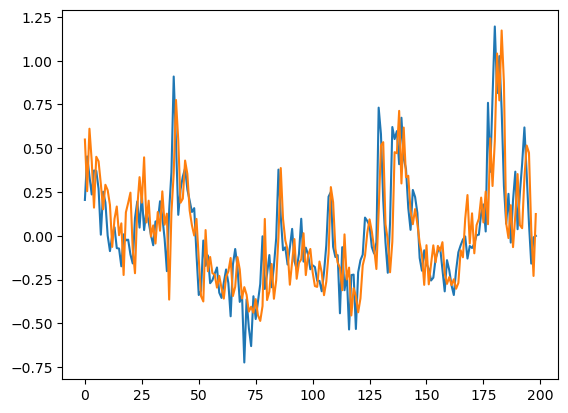

In [24]:
spyHistIV = pd.read_pickle('historicImpliedVolData/spc_mean_iv_2017_2022.pkl')
evaluate_model(*preprocess_data(spyHistIV,'^GSPC',60)) ;

Mean Squared Error: 0.11620396830131759
Root Mean Squared Error: 0.34088703158277756
Mean Absolute Error: 0.2555594902025749
R squared: 0.6060511300856545


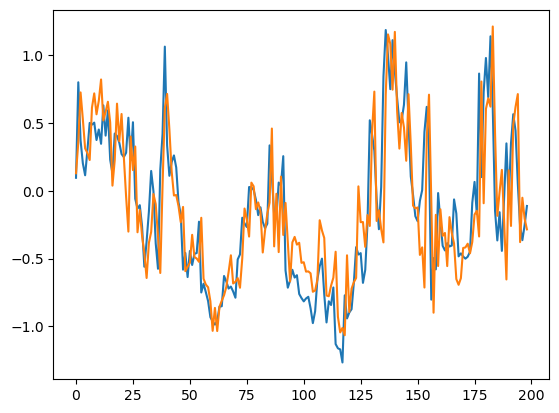

In [30]:
evaluate_model(*preprocess_data(googHistIV,'GOOG',60)) ;


Mean Squared Error: 0.08054723222279854
Root Mean Squared Error: 0.28380844283213025
Mean Absolute Error: 0.21356661146599393
R squared: 0.4584663136859902


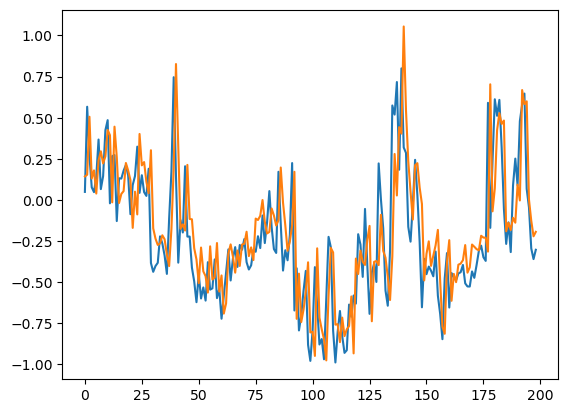

In [28]:
evaluate_model(*preprocess_data(msftHistIV,'MSFT',60)) ;

Mean Squared Error: 0.059418317599425105
Root Mean Squared Error: 0.24375872825280556
Mean Absolute Error: 0.1827936513328495
R squared: 0.5627167274343812


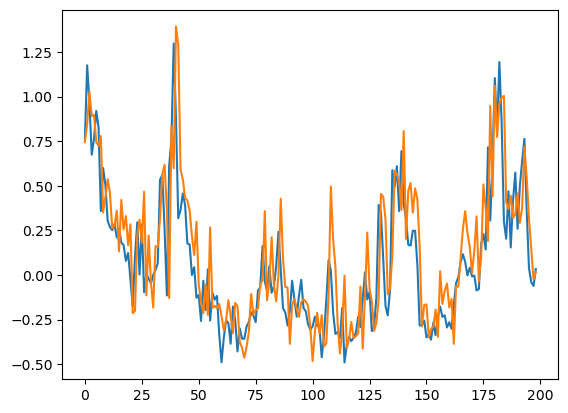

In [29]:
evaluate_model(*preprocess_data(ndxHistIV,'NDX',60)) ;s